In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from neural_net import feedForwardNet
from pendulum_utils import terminalPendulum, Solver, Datagen
import matplotlib.pyplot as plt
import example_robot_data
import crocoddyl
from crocoddyl.utils.pendulum import CostModelDoublePendulum, ActuationModelDoublePendulum

%matplotlib inline

In [67]:
test = Datagen.samples(size = 2,sampling='uniform', as_tensor=False, th1_lims=[-1, 1], th2_lims=[-1,1])

In [68]:
test_data = test[0]

In [69]:
positions, values = Datagen.statesValues(init_states=test_data, full_traj=True,as_tensor=False)

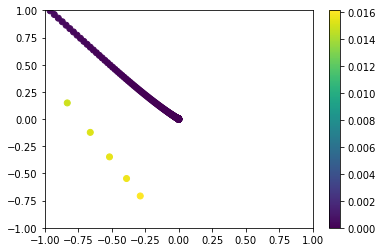

In [70]:

plt.scatter(positions[:,0], positions[:,1], c = values)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.colorbar()

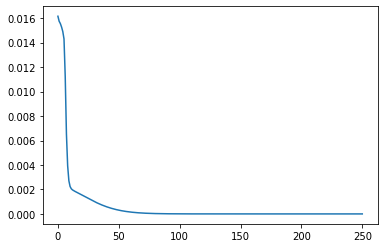

In [71]:
plt.plot(values)

In [79]:
net10 = torch.load('./nets/net30.pth')
net10.double()

feedForwardNet(
  (activation): Tanh()
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [80]:
p = torch.tensor(positions)
v = net10(p).detach().numpy()

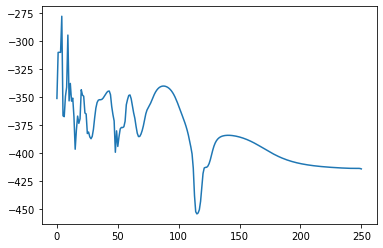

In [82]:
plt.plot(v)


In [100]:
grid = Datagen.samples(size = 50, sampling='grid', as_tensor=True, th1_lims=[-1, 1], vel1_lims=[-1,1])

In [101]:
p_g = net10(grid).detach().numpy()

In [102]:
grid_ = grid.detach().numpy()

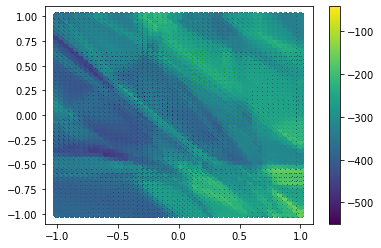

In [103]:
plt.scatter(grid_[:,0], grid_[:,1], c = p_g)
plt.colorbar()

In [104]:
p_g

array([[-333.57355916],
       [-335.88446065],
       [-339.02842548],
       ...,
       [-324.8084567 ],
       [-326.50979584],
       [-328.79624875]])

In [75]:
class _terminalPendulum(crocoddyl.ActionModelAbstract):
    """
    This includes a feedforward network in crocoddyl
    
    """
    def __init__(self, neural_net, robot):
        crocoddyl.ActionModelAbstract.__init__(self,
                                               crocoddyl.StateMultibody(robot),
                                               0,0)
        
        self.net = neural_net
        self.net.double()
    def calc(self, data, x, u=None):
        if u is None:
            u = self.unone
            
        x = torch.tensor(x, dtype = torch.float64).resize_(1, 4)
        
        # Get the cost
        with torch.no_grad():
            data.cost = self.net(x).item()
            
    def calcDiff(self, data, x, u=None):
        if u is None:
            u = self.unone
            
        # This is irritating. Converting numpy to torch everytime.
        x = torch.tensor(x, dtype = torch.float64).resize_(1, 4)
        
        data.Lx = self.net.jacobian(x).detach().numpy()
        data.Lxx = self.net.hessian(x).detach().numpy()
            

In [58]:
robot = example_robot_data.loadDoublePendulum()
robot_model = robot.model
terminal_model = _terminalPendulum(net10, robot_model)
state = crocoddyl.StateMultibody(robot_model)
actModel = ActuationModelDoublePendulum(state, actLink=1)

weights = np.array([1.5, 1.5, 1, 1] + [0.1] * 2)
runningCostModel = crocoddyl.CostModelSum(state, actModel.nu)
dt = 1e-2

xRegCost = crocoddyl.CostModelState(state, 
                                    crocoddyl.ActivationModelQuad(state.ndx),
                                    state.zero(),
                                    actModel.nu)

uRegCost = crocoddyl.CostModelControl(state,
                                      crocoddyl.ActivationModelQuad(1),
                                      actModel.nu)
xPendCost = CostModelDoublePendulum(state, 
                                    crocoddyl.ActivationModelWeightedQuad(weights),
                                    actModel.nu)

runningCostModel.addCost("uReg", uRegCost, 1e-4 / dt)
runningCostModel.addCost("xGoal", xPendCost, 1e-5 / dt)

runningModel = crocoddyl.IntegratedActionModelEuler(
                                                crocoddyl.DifferentialActionModelFreeFwdDynamics(state,
                                                actModel,
                                                runningCostModel),
                                                dt)


x0 = test_data.astype(np.float64)
problem = crocoddyl.ShootingProblem(x0, [runningModel] * 250, terminal_model)
fddp = crocoddyl.SolverFDDP(problem)
fddp.th_stop = 1e-7


fddp.solve([], [], 2000)


False

In [59]:
fddp.isFeasible

False